# Readme 

****************************
Motion detection project
****************************
ver. 5.0

Authors:

Anna Grzywa
Agnieszka Tracz
Adriana Zlahoda
Andrzej Czechowski
Michal Kluska
Maciej Stanuch
Adam Szmatula


This project is a data analysis of an 8-channels recorded EMG signal of 6 specific hand movements.
The 6 movements of 7 volunteers were registered as follows:

1. finger snap
2. hand shaking
3. double click betweem the thumb and the middle finger
4. right swap
5. left swap
6. fist

For every channel were defined the following  features:

12 time parameters were measured:
	maximum
	minimum
	mean
	std
	median
	median absolute deviation
	signal magnitude area
	energy
	interquartile range
	duration time
	entropy
	autocorrelation

4 frequency parameters:
	leading frequency
	weighted frequency
	skewness
	curtosis

The Pan-Tompkins algorithm was used to detect the beginning and end of the motion in the signal.

After calculating the average feature for each gesture for 5 out of 7 persons, 
a pattern was created and normalised to the [0, 1] range.

A transfer function was defined thanks to which each following motion
is normalised according to the pattern.

The feature vectors for each gesture for each person were compared 
with each base vector (pattern) by a scalar product.

The threshold is set in order to determine the similarity between the movements 
and qualify the correct gesture.

A statystical analysis was processed to check were the algorithm is correct and were it is not
by determining the accuracy, sensitivity and specificity but also a ROC curve.

It appears that the scalar product is the most efficient measure of similarity between vectors.

A PCA analysis of the feature vectors was processed to determine which parameter best determine a gesture.
Applying different weights to those parameters improves the algorithm efficiency
by discriminating the least influent parameters.


In [1]:
import numpy as np
import pandas as pd

import scipy.stats
import scipy.signal
import scipy.spatial.distance

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import math
import os
import copy

import unittest

from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict
from enum import Enum, IntEnum

def listdirNoHidden(path):
    result = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            result.append(f)
    return result

In [2]:
class measType(Enum):
    accelerometer = 0
    emg = 1
    gyro = 2
    orientation = 3
    orientationEuler = 4

In [3]:
class MeasTypeFilter(): 
    def getKindOfMeas(self, filename):
        return filename.split('-')[-2].split('/')[-1]

    def getMeasByType(self, measType, data) :
        return list(filter(lambda x: self.getKindOfMeas(x) == measType.name, 
                           data))

In [4]:
class DataReader() : 
    def __init__ (self, path):
        self.__commonInitialization__()
        self.path = path
        self.readSubjectsList()
        self.readAllMeas()
        
    def __commonInitialization__(self):
        self.examinedSubjects = []
        self.personsGestures = []
        self.MeasurementsList = []
        self.measTypeFilter = MeasTypeFilter()

    def getAllPersonFiles(self, personId, gestureId, isShouldIncludeFullPath):
        if isShouldIncludeFullPath == True:
            return self.createFullPathToMeas(personId, gestureId,
                                             self.MeasurementsList[personId][gestureId])
        else:
            return self.MeasurementsList[personId][gestureId]
    
    def getSpecificPersonMeas(self, personId, gestureId, measType, isShouldIncludeFullPath):
        return self.measTypeFilter.getMeasByType(measType,
                                                 self.getAllPersonFiles(personId,
                                                                        gestureId,
                                                                        isShouldIncludeFullPath))                                                                                                 
    def readSubjectsList(self): 
        self.examinedSubjects = listdirNoHidden(path)
        self.personsGestures.clear()
        for subject in self.examinedSubjects:
            subjectList = listdirNoHidden(self.path + "/" + subject)
            self.personsGestures.append(subjectList)
                  
    def getDims(self, data):
        #getting dimension of folderListForPersons
        return np.shape(data)
    
    def readAllMeas(self): 
        self.MeasurementsList.clear()
        [self.noPerson, self.noGesture] = self.getDims(self.personsGestures)
        for personId in range(0, self.noPerson):
            personGestures = []
            for gestureId in range(0, self.noGesture):
                personGestures.append(listdirNoHidden(self.path + "/" + self.examinedSubjects[personId] + "/"  \
                                                        + self.personsGestures[personId][gestureId]))
            self.MeasurementsList.append(personGestures)
                                            
    def createFullPathToMeas(self, personId, gestureId, meas):
        return [self.path + "/" + self.examinedSubjects[personId] + "/" + \
               self.personsGestures[personId][gestureId] + "/" + \
               x for x in meas]

In [5]:
class Common:
    @staticmethod
    def index(array, item):
        for idx, val in np.ndenumerate(array):
            if val == item:
                return idx
            
    @staticmethod    
    def mad(data, axis = None):
        return np.mean(np.absolute(data - np.mean(data, axis)), axis)
    
    @staticmethod
    def sma(data):
        suma = np.sum(abs(data))
        dlugosc = np.size(data)
        return suma / dlugosc

    @staticmethod    
    def energy(data):
        suma = np.sum(pow(data, 2))
        dlugosc = np.size(data)
        return suma / dlugosc

    @staticmethod
    def iqr(data):
        q75, q25 = np.percentile(data, [75, 25])
        return q75 - q25
    
    @staticmethod
    def power(vector, power):
        return [ x ** power for x in vector ]
    
    @staticmethod
    def scalarSimilarity(vector1, vector2):
        result1 = np.dot(vector1, vector2)
        return result1 / (np.sqrt(sum(Common.power(vector1, 2))) * np.sqrt(sum(Common.power(vector2, 2))))
    
    @staticmethod
    def distanceSimilarity(vector1, vector2):
        return scipy.spatial.distance.pdist([vector1, vector2], 'euclidean')
    

In [6]:
def getSignalEnvelope(signal): 
    analyticalSignal = scipy.signal.hilbert(signal)
    return np.absolute(analyticalSignal)

In [7]:
class timeFeature(IntEnum):
    maximum = 0
    minimum = 1
    mean = 2
    std = 3
    median = 4
    mad = 5 #median absolute deviation
    sma = 6 #SignalMagnitudeArea
    energy = 7
    iqr = 8 # rozstep miedzykwartylowy
    durationTime = 9
    entropy = 10
    autocorrelation = 11
    
class frequencyFeature(IntEnum) :
    leadingFreq = 0
    weightedFreq = 1
    skewness = 2
    curtosis = 3
    
class envelopeFeature(IntEnum): 
    leadingFreq = 0
    
class FeaturesEnum(IntEnum): 
    maximum = 0
    minimum = 1
    mean = 2
    std = 3
    median = 4
    mad = 5 #median absolute deviation
    sma = 6 #SignalMagnitudeArea
    energy = 7
    iqr = 8 # rozstep miedzykwartylowy
    durationTime = 9
    leadingFreq = 10
    weightedFreq = 11
    skewness = 12
    curtosis = 13

class IFeatureExtractor: 
    def calculateFeatures(self, data, Fs):
        raise NotImplementedError 
     
    def getFeatureVec(self):
        raise NotImplementedError 

        
class TimeSeriesFeatureExtractor(IFeatureExtractor):
    def __init__(self): 
        IFeatureExtractor.__init__(self)
    
    def calculateFeatures(self, data, Fs): 
        maximum = np.max(data)
        minimum = np.min(data)
        mean = np.mean(data)
        std = np.std(data)
        median = np.median(data)
        mad = Common.mad(data)
        sma = Common.sma(data)
        energy = Common.energy(data)
        iqr = Common.iqr(data)
        durationTime = len(data) / Fs

        self.timeSeriesFeatures = [maximum, minimum, mean,
                                   std, median, mad, sma, energy,
                                   iqr, durationTime]
        
        return self.timeSeriesFeatures
            
    def getParameter(self, parameter):
        return self.timeSeriesFeatures[parameter]
    
    def getFeatureVec (self) : 
        return self.timeSeriesFeatures
    
class FrequencyFeatureExtractor(IFeatureExtractor):
    def __init__(self) : 
        IFeatureExtractor.__init__(self)
    
    def calculateFeatures(self, timeDomainData, Fs): 
        fft = self.performFFT(timeDomainData) 
        freqsVec = self.prepareFreqsVec(len(fft), Fs)
        leadingFreq = np.argmax(fft[1::]) * Fs / len(timeDomainData)
        weightedFreq = self.calcWeightedFreq(freqsVec, fft)
        skewness = self.calcSkewness(fft)
        curtosis = self.calcCurtosis(fft)
        self.freqFeatures = [leadingFreq, weightedFreq, skewness, curtosis]
        return self.freqFeatures
        
    def getFeatureVec(self): 
        return self.freqFeatures
    
    def getParameter(self, parameter):
        return self.freqFeatures[parameter]
    
    def performFFT(self, timeDomainData): 
        half = math.floor(len(timeDomainData) / 2) + 1
        return np.absolute(np.fft.fft(timeDomainData)[0 : half])
    
    def prepareFreqsVec(self, noProbes, Fs):
        return np.linspace(0, Fs/2, noProbes)
    
    def calcWeightedFreq(self, freqsVec, FFT):
        return np.sum(freqsVec * FFT) / np.sum(FFT)
        
    def calcCurtosis(self, data):
        meanData = np.mean(data)
        stdData  = np.std(data)
        return (((meanData - stdData)**4) / (((meanData - stdData)**2)**(2))) - 3
    
    def calcSkewness(self, data):
        meanData = np.mean(data)
        stdData  = np.std(data)
        return ((meanData - stdData)**3) / (((meanData - stdData)**2)**(3/2))
    
class EnvelopeFeatureExtractor(IFeatureExtractor): 
    def __init__(self) : 
        IFeatureExtractor.__init__(self)
        
    def calculateFeatures(self, signal, Fs) : 
        envelope = getSignalEnvelope(signal)
        fft = self.performFFT(envelope)
        
        return np.argmax(fft[1::]) * Fs / len(signal)
        
    def performFFT(self, signal) : 
        half = math.floor(len(signal) / 2) + 1
        return np.absolute(np.fft.fft(signal)[0 : half])
    
    
class FeatureExtractor(IFeatureExtractor):     
    def __init__(self) :
        IFeatureExtractor.__init__(self)
        self.frequencyFeatureExtractor = FrequencyFeatureExtractor()
        self.timeSeriesFeatureExtractor = TimeSeriesFeatureExtractor()
        self.envelopeFeatureExtractor = EnvelopeFeatureExtractor()
        
    def calculateFeatures(self, data, Fs): 
        freqDomainFeatures = self.frequencyFeatureExtractor.calculateFeatures(data, Fs)
        timeDomainFeatures = self.timeSeriesFeatureExtractor.calculateFeatures(data,Fs)
        envelopeFeature = self.envelopeFeatureExtractor.calculateFeatures(data,Fs)
        
        self.features = timeDomainFeatures + freqDomainFeatures
        
        return self.features
    
    def getFeatureVec(self): 
        return self.features

In [8]:
class PanTompkinsAlgorithm:
    def processAlgorithm (self, signal): 
        diffSignal = self.__diffSignal(signal)
        powSignal = self.__powerSignal(diffSignal)
        return self.__integrateSignal(powSignal)
        
    def __diffSignal(self, signal):
        diff = (-2, -1, 1, 2)
        diff = [1/8 * x for x in diff]
        return np.convolve(signal, diff, mode = 'same')
    
    def __powerSignal(self, signal):
        return [pow(x,2) for x in signal]
    
    def __integrateSignal(self, signal, WindowLength = 150): 
        window = scipy.signal.blackman(WindowLength)
        return np.convolve(signal, window, mode = 'same')

In [9]:
class SignalCropper:
    def cropSignal(self, signal, referenceSignal, startThreshold = 0.1, endThreshold = 0.1): 
        if isinstance(referenceSignal, list) :
             [startIndex, endIndex] = self.__cropSignal(referenceSignal, startThreshold, endThreshold)
        else:
            [startIndex, endIndex] = self.__cropSignal(referenceSignal.tolist(), startThreshold, endThreshold)
            
        return signal[startIndex : endIndex]
             
    def __cropSignal(self, signal, startThreshold = 0.1, endThreshold = 0.1): 
        startInd = signal.index(next(x for x in signal        if x > startThreshold * np.max(signal)))
        endIndex = signal.index(next(x for x in signal[::-1]  if x > endThreshold * np.max(signal)))
        
        return [startInd, endIndex]

In [10]:
class IDataAnalyser:
    def processData(data, Fs):
        raise NotImplementedError 
    
class AccelerometerDataAnalyser(IDataAnalyser):
    def __init__(self): 
        IDataAnalyser.__init__()
    
    def processData (self, data, Fs): 
        dataX=data['x']
        dataY=data['y']
        dataZ=data['z']
        return [dataX, dataY, dataZ]  

In [11]:
class EMGDataAnalyser(IDataAnalyser):
    def __init__ (self): 
        IDataAnalyser.__init__(self)
        self.panTompkins = PanTompkinsAlgorithm()
        self.signalCropper = SignalCropper()
        self.featureExtractor = FeatureExtractor()
        self.headers = ['emg1','emg2', 'emg3','emg4','emg5','emg6','emg7','emg8']
    
    def processData(self, data, Fs):
        features = list()
        for header in self.headers:
            emgSignal = data[header]
            if self.isValid(emgSignal): 
                croppedSignal = self.signalCropper.cropSignal(emgSignal, self.panTompkins.processAlgorithm(emgSignal))
                features = features + list(self.featureExtractor.calculateFeatures(croppedSignal, Fs))
        return features
    
    def isValid (self, data): 
        return len(data) != 0

In [12]:
class Measurement: 
    def __init__(self, personId, gestureId, features): 
        self.personId = personId
        self.gestureId = gestureId
        self.features = features
        
    @staticmethod
    def getFeatures(data):
        if data:
            return [x.features for x in data]
        else: 
            list()
        
    def __eq__(self, other):
        return self.personId == other.personId and \
               self.gestureId == other.gestureId and \
               self.features == other.features


In [13]:
class ExaminationData:
    def __init__(self): 
        self.examinationData = []
        
    def addExamination(self, examination): 
        if examination.features:
            self.examinationData.append(examination)
        
    def filterData(self, comparator): 
        return list(filter(comparator, self.examinationData))

In [14]:
class Channel(IntEnum): 
    emg1 = 0 
    emg2 = 1
    emg3 = 2 
    emg4 = 3
    emg5 = 4
    emg6 = 5
    emg7 = 6
    emg8 = 7

class channelSelector: 
    @staticmethod
    def getChannelFeatures (Features, channel): 
        return [x [channel.value * len(FeaturesEnum) : (channel.value + 1) * len(FeaturesEnum)] for x in Features ]

In [15]:
class FeaturesOfGesture: 
    def __init__(self, gestureId, features):
        self.gestureId = gestureId
        self.features = features 
        
    @staticmethod
    def getFeatureVector(data):
        if data:
            return data[0].features
        else:
            list()
        
    def __eq__(self, other):
        return self.gestureId == other.gestureId and \
               self.features == other.features

In [16]:
class minMaxTuple: 
    def __init__(self, min_, max_) : 
        self.min = min_
        self.max = max_
        
    def __str__(self):
        print("min: ", min_, " max: ", max_)
        
    def __eq__(self, other) : 
        return self.min == other.min and \
               self.max == other.max

In [17]:
class FeaturesNormalizator:   
    def normalizeVectors (self, featuresVectorsToNormalization): 
            self.__checkCorrectnessOfFeaturesVectorsDims(featuresVectorsToNormalization) 
            minMaxBasisVector = self.__buildMinMaxBasisVectorForEveryFeatureInFeaturesVector(featuresVectorsToNormalization)
            normalizedFeaturesVectors = self.normalizeFeaturesVectors(featuresVectorsToNormalization, 
                                                                      minMaxBasisVector)
            return normalizedFeaturesVectors, minMaxBasisVector

    def normalizeFeaturesVectors(self, featuresVectorsToNormalization, minMaxBasisVector): 
        if all(isinstance(elem, list) for elem in featuresVectorsToNormalization): 
            return self.__normalizeFeaturesVectors(featuresVectorsToNormalization, minMaxBasisVector)      
        else:
            return self.__normalizeSingleList(featuresVectorsToNormalization, minMaxBasisVector)
         
    def __normalizeSingleList(self, featuresVectorToNormalization, minMaxBasisVector):
        assert len(featuresVectorToNormalization) == len(minMaxBasisVector), "Different sizes!"
        noFeatures = len(featuresVectorToNormalization)
        normalizedVectors = copy.deepcopy(featuresVectorToNormalization)
        for i in range(0, noFeatures):
            range_ = minMaxBasisVector[i].max - minMaxBasisVector[i].min
            if range_ == 0 : # nie chce mi się testów zmieniać :D 
                range_ = range_ + 10E-12   
            normalizedVectors[i] = (featuresVectorToNormalization[i] - minMaxBasisVector[i].min) / (range_)   
        return normalizedVectors    
        
    def __normalizeFeaturesVectors(self, featuresVectorsToNormalization, minMaxBasisVector): 
        assert len(featuresVectorsToNormalization[0]) == len(minMaxBasisVector), "Different sizes!"
        noFeatures = len(featuresVectorsToNormalization[0])
        noVectorsOfFeatures = len(featuresVectorsToNormalization)
        normalizedVectors = copy.deepcopy(featuresVectorsToNormalization)
        for i in range(0, noFeatures):
            range_ = minMaxBasisVector[i].max - minMaxBasisVector[i].min
            if range_ == 0 : # nie chce mi się testów zmieniać :D 
                range_ = range_ + 10E-12 
            for j in range(0, noVectorsOfFeatures):
                  normalizedVectors[j][i] = (featuresVectorsToNormalization[j][i] - minMaxBasisVector[i].min) / (range_)  
        return normalizedVectors    
        
    def __checkCorrectnessOfFeaturesVectorsDims(self, featuresVectorsToNormalization): 
        assert featuresVectorsToNormalization != None, "Empty features' vector!"
        noFeatures = len(featuresVectorsToNormalization[0])
        for featureVector in featuresVectorsToNormalization: 
            assert len(featureVector) == noFeatures, "Features vectors have different sizes!"
            
    def __buildMinMaxBasisVectorForEveryFeatureInFeaturesVector(self, featuresVectorsToNormalization):
        noFeatures = len(featuresVectorsToNormalization[0])
        noVectorsOfFeatures = len(featuresVectorsToNormalization)
        minMaxBasisVector = list()
        for i in range(0, noFeatures):
            min_ = featuresVectorsToNormalization[0][i]
            max_ = featuresVectorsToNormalization[0][i]
            for j in range(1, noVectorsOfFeatures):
                if featuresVectorsToNormalization[j][i] > max_: 
                    max_ = featuresVectorsToNormalization[j][i]
                    continue
                if featuresVectorsToNormalization[j][i] < min_: 
                    min_ = featuresVectorsToNormalization[j][i]
            minMaxBasisVector.append(minMaxTuple(min_, max_))
        return minMaxBasisVector

In [18]:
class FeatureContainer:
    def __init__(self) : 
        self.normalizator = FeaturesNormalizator()
        self.unnormalizedFeaturesContainer = list()
        self.normalizedFeaturesContainer = list()
        self.minMaxDataBasis = list()
        
    def addNewGestureToDatabase(self, data, gestureId): 
        feature = self.__calculateAverageOfVector(data)
        self.unnormalizedFeaturesContainer.append(FeaturesOfGesture(gestureId, feature))
        [normalizedFeatures, self.minMaxDataBasis ] = \
            self.normalizator.normalizeVectors(list(map( lambda x: x.features, self.filterUnnormalizedData(lambda x : True))))
        gestures = list(map( lambda x: x.gestureId, self.filterUnnormalizedData(lambda x : True))) 
        self.normalizedFeaturesContainer = list(map(lambda gesture, features : FeaturesOfGesture(gesture, features),
                                                    gestures,
                                                    normalizedFeatures)) 
        
    def filterUnnormalizedData(self, comparator): 
        return list(filter(comparator, self.unnormalizedFeaturesContainer))
    
    def filterNormalizedData(self, comparator): 
        return list(filter(comparator, self.normalizedFeaturesContainer))
    
    def normalizeData(self, data): 
        return self.normalizator.normalizeFeaturesVectors(data, self.minMaxDataBasis)
    
    def __calculateAverageOfVector(self, data):
        noMeas = len(data)
        if(noMeas == 0): 
            return 
        noFeatures = len(data[0])
        meanVector = list()
        for i in range(0,noFeatures):
            suma = 0
            omitted = 0
            for j in range(0,noMeas):
                if data[j][:] : 
                    suma = suma + data[j][i]
                else:
                    omitted = omitted + 1
            meanVector.append(suma / (noMeas - omitted))   
        return meanVector

In [19]:
class SimilarityChecker:
    def findTrueValuesIndex(self, vector):
        trueInd = []
        for i in range(0, len(vector)):
            if(vector[i] == True):
                trueInd.append(i)
        return trueInd

    def checkVectorByThreshold(self, vector, threshold):
        return [ x > threshold for x in vector ]
    
    def calcBasicStatisticsBasedOnThreshold(self, gestures, allGesturesSimilarity, thresholdValue) :
        TP = []
        FP = []
        P = []
        N = []
        for templateGestureName in gestures :
            for gesture in gestures :
                currentSum = sum(self.checkVectorByThreshold(                                                      \
                                                             allGesturesSimilarity[int(templateGestureName[4])-1]  \
                                                                                  [int(gesture[4])-1]              \
                                                                                  [:],                             \
                                                                                  thresholdValue                             \
                                                            )
                                )

                if (templateGestureName == gesture):
                    TP.append(currentSum)
                    P.append(len(allGesturesSimilarity[int(templateGestureName[4])-1][int(gesture[4])-1][:]))
                else :
                    FP.append(currentSum)
                    N.append(len(allGesturesSimilarity[int(templateGestureName[4])-1][int(gesture[4])-1][:]))
        
        return [sum(TP), sum(FP), sum(P), sum(N)]
    
    def calcAdvancedStatisticsBasedOnBasicStat(self, TP, FP, P, N) :
        TN = N - FP
        FN = P - TP
        TPR = TP / P #sensitivity
        TNR = TN / N # specifity
        FPR = FP / N # fall-out, false positive rate
        PPV = TP / (TP + FP) # precision
        ACC = (TP + TN) / (P + N) # accuracy
        FNR = FN / P # false negative rate
        
        return [TN, FN, TPR, TNR, FPR, PPV, ACC, FNR]

In [20]:
#Unit testy - czy wszystko ok
class TestOfUnitTestFramework(unittest.TestCase):    
    def test_equal (self) : 
        self.assertEqual(1, 1)

class ExaminationDataTestSuite(unittest.TestCase):
    def setUp(self) : 
        self.examinationData = ExaminationData()
        self.basicMeas =  Measurement("osoba1", "gest1", [1, 2, 3, 4, 5, 6, 7, 8])
        self.basicMeas2 = Measurement("osoba1", "gest2", [1, 2, 3, 4, 5, 6, 7, 8])
        self.basicMeas3 = Measurement("osoba2", "gest2", [8, 7, 6, 5, 4, 3, 2, 1])
        self.examinationData.addExamination(self.basicMeas)
        self.examinationData.addExamination(self.basicMeas2)
        self.examinationData.addExamination(self.basicMeas3)
        
    def test_filterDataShouldReturnOneGestWhenInDataBaseIsOneGesture1(self): 
        filteredData = self.examinationData.filterData(lambda x: x.gestureId == "gest1")
        self.assertEqual(len(filteredData), 1)
        self.assertEqual(filteredData[0], self.basicMeas)
        
    def test_filterDataShouldReturnTwoGestureWhenInDataBaseIsTwoGesture2(self): 
        filteredData = self.examinationData.filterData(lambda x: x.gestureId == "gest2")
        self.assertEqual(len(filteredData), 2)
        self.assertEqual(filteredData[0], self.basicMeas2)
        self.assertEqual(filteredData[1], self.basicMeas3)
        
    def test_filterDataShouldReturnSecondGestureFromSecondPerson(self): 
        filteredData = self.examinationData.filterData(lambda x: x.gestureId == "gest2" and x.personId == "osoba1")
        self.assertEqual(len(filteredData), 1)
        self.assertEqual(filteredData[0], self.basicMeas2)
        
    def test_filterDataShouldReturnEmptyListWhenGestureIsNotInDataBase(self): 
        filteredData = self.examinationData.filterData(lambda x: x.gestureId == "gest3")
        self.assertEqual(len(filteredData), 0)
        
    def test_shouldNotAddedRecordWithEmptyFeaturesListToDataBase(self): 
        self.assertEqual(len(self.examinationData.examinationData), 3)
        self.examinationData.addExamination(Measurement("osoba1", "gest1", list()))
        self.assertEqual(len(self.examinationData.examinationData), 3)
        
class FeatureContainerTestSuite(unittest.TestCase):
    def setUp(self):
        self.featureContainer = FeatureContainer()
        self.FeaturesList1 = [[0,   0,   0,   0,   0,   0], 
                              [100, 200, 300, 400, 500, 600]]    
        self.AverageGesture1 = [50, 100, 150, 200, 250, 300]        
        self.FeaturesList2 = [[0,  0,  0,  0,  0,  0], 
                              [1,  2,  3,  4,  5,  6],
                              [14, 13, 12, 11, 10, 9]]
        self.AverageGesture2 = [5, 5, 5, 5, 5, 5]
        
    def test_shouldCorrectlyCalculateAverageVector(self):
        self.featureContainer.addNewGestureToDatabase(self.FeaturesList1, "gest1")
        self.assertEqual(len(self.featureContainer.unnormalizedFeaturesContainer), 1)
        self.assertEqual(self.featureContainer.unnormalizedFeaturesContainer[0].features,
                         self.AverageGesture1)
        
    def test_shouldCorrectlyCalculateAverageVectorInCaseThreeMeas(self):
        self.featureContainer.addNewGestureToDatabase(self.FeaturesList2, "gest1")
        self.assertEqual(len(self.featureContainer.unnormalizedFeaturesContainer), 1)
        self.assertEqual(self.featureContainer.unnormalizedFeaturesContainer[0].features,
                         self.AverageGesture2)
        
    def test_filterDataShouldReturnFeaturesOfGestureForGesture1 (self) : 
        self.featureContainer.addNewGestureToDatabase(self.FeaturesList1, "gest1")
        self.featureContainer.addNewGestureToDatabase(self.FeaturesList2, "gest2")
        filterData = self.featureContainer.filterUnnormalizedData(lambda x: x.gestureId == "gest1")
        self.assertEqual(len(filterData), 1)
        self.assertEqual(filterData[0], FeaturesOfGesture("gest1", self.AverageGesture1))
        
class MeasurementGetterTestSuite(unittest.TestCase): 
    def setUp(self):
        self.examinationData = ExaminationData()
        self.basicMeas =  Measurement("osoba1", "gest1", [1, 2, 3, 4, 5, 6, 7, 8])

    def test_getFeatureShouldReturnListOfFeatures(self) : 
        self.examinationData.addExamination(self.basicMeas)
        filteredData = Measurement.getFeatures(self.examinationData.filterData(lambda x: True))
        self.assertEqual(len(filteredData), 1)
        self.assertEqual(filteredData, [[1, 2, 3, 4, 5, 6, 7, 8]])
        
    def test_getFeatureShouldReturnEmptyListIfFilteredDataIsEmpty (self):
        filteredData = Measurement.getFeatures(self.examinationData.filterData(lambda x: True))
        self.assertEqual(filteredData, None)
        
class FeatureGetterTestSuite(unittest.TestCase) : 
    def setUp(self):
        self.featureContainer = FeatureContainer()
        self.FeaturesList1 = [[0,   0,   0,   0,   0,   0], 
                              [100, 200, 300, 400, 500, 600]] 
        self.AverageGesture1 = [50, 100, 150, 200, 250, 300]
        
    def test_getFeatureShouldReturnFeaturesVector(self): 
        self.featureContainer.addNewGestureToDatabase(self.FeaturesList1, "gest1")
        filteredData = FeaturesOfGesture.getFeatureVector(self.featureContainer.filterUnnormalizedData(lambda x : True))
        self.assertEqual(filteredData, self.AverageGesture1)
    
    def test_getFeatureShouldReturnEmptyListIfFilteredDataIsEmpty(self): 
        filteredData = FeaturesOfGesture.getFeatureVector(self.featureContainer.filterUnnormalizedData(lambda x : True))
        self.assertEqual(filteredData, None)
        
class FeatureNormalizatorTestSuite(unittest.TestCase): 
    def setUp (self) : 
        self.featuresNormalizator = FeaturesNormalizator()
        self.featureList = [[  0, -10, 20, 100], 
                            [100,  10, 40,   0],
                            [ 25,   0, 60,  10]]
    
    def test_shouldCorrectNormalizeData(self): 
        [normalizedFeaturesVectors, minMaxBasis] = self.featuresNormalizator.normalizeVectors(self.featureList)
        expectedLists = [[ 0.0, 0.0, 0.0, 1.0],
                         [ 1.0, 1.0, 0.5, 0.0],
                         [0.25, 0.5, 1.0, 0.1]]
        expectedMinMaxBasis = [minMaxTuple(0, 100), minMaxTuple(-10, 10), minMaxTuple(20, 60), minMaxTuple(0, 100)] 
        self.assertEqual(expectedMinMaxBasis, minMaxBasis)
        self.assertEqual(expectedLists, normalizedFeaturesVectors)

In [21]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)

..............
----------------------------------------------------------------------
Ran 14 tests in 0.014s

OK


In [26]:
# liczy się długo, trzeba poczekać, aż gwiazkdka z lewej zniknie
path = "C:/Users/Maciek/Desktop/projekt_gesty/projekt_gesty"    
dataReader = DataReader(path)
[noPersons, noGesture] = dataReader.getDims(dataReader.personsGestures)

examinationData = ExaminationData()
emgDataAnalyser = EMGDataAnalyser()
featureContainer = FeatureContainer()

gestureFeaturesById = []
personFeaturesById = []

for personId in range(0, noPersons):
    for gestureId in range(0, noGesture): 
        emgData = dataReader.getSpecificPersonMeas(personId, gestureId, measType.emg, True)    
        
        for examination in range(0, len(emgData)): 
            DaneEMG = pd.read_csv(emgData[examination], encoding='ISO-8859-1', low_memory=False)
            Fs = 200
            features = emgDataAnalyser.processData(DaneEMG, Fs)
            examinationData.addExamination(Measurement(dataReader.examinedSubjects[personId],
                                                       dataReader.personsGestures[personId][gestureId],
                                                       features))

In [27]:
# w tym miejscu dodajemy i uśredniamy wszystkie gesty dla 5 z 7 osób ( z pominięciem osoby 1 i 2)
gestures = ["gest1", "gest2", "gest3", "gest4", "gest5", "gest6"]

for gesture in gestures:    
    selectedGest = Measurement.getFeatures(examinationData.filterData(lambda x: x.gestureId == gesture \
                                               and x.personId != "osoba1" \
                                               and x.personId != "osoba2"))    
    
    featureContainer.addNewGestureToDatabase(selectedGest, gesture)                                                    

In [28]:
# 1. PCA
# PCA wektorów cech i określenie, która cecha jest najistotniejsza
# Ustanowienie wag dla poszczególnych cech

# 2. Statystyki
# Wykreślenie parametrów związanych z ROC dla różnych thresholdów
# (TruePositive, FalsePositive, TrueNegative, FalseNegative), accuracy, sensitivity, krzywe FRR, FAR

In [29]:
allGesturesSimilarity = []
for templateGestureName in gestures:
    featuresSimiliarityVector = []
    AllGestureVec = []
    for gesture in gestures:

        evaluationGesture = Measurement.getFeatures(examinationData.filterData(lambda x: x.gestureId == gesture))
        evaluationGesture = featureContainer.normalizeData(evaluationGesture)
        AllGestureVec.append(evaluationGesture)
        featureGestureTemplate = FeaturesOfGesture.getFeatureVector(
                                    featureContainer.filterNormalizedData(lambda x : x.gestureId == templateGestureName))

        featuresSimilarity = []
        for j in range(0, len(evaluationGesture)):
            featuresSimilarity.append(Common.scalarSimilarity(featureGestureTemplate,evaluationGesture[j][:]))
            
        featuresSimiliarityVector.append(featuresSimilarity)
    allGesturesSimilarity.append(featuresSimiliarityVector)

In [30]:
similarityChecker = SimilarityChecker()

thresholdValues = np.round(np.linspace(0,0.99,100),4)

statisticValues = []
TP = []
FP = []
P = []
N = []
TN = []
FN = []
TPR = []
TNR = []
FPR = []
FPR = []
PPV = []
ACC = []
FNR = []

for thresholdValue in thresholdValues :
    [TP_buffer, FP_buffer, P_buffer, N_buffer] = similarityChecker.calcBasicStatisticsBasedOnThreshold(gestures, allGesturesSimilarity, thresholdValue)
    [TN_buffer, FN_buffer, TPR_buffer, TNR_buffer, FPR_buffer, PPV_buffer, ACC_buffer, FNR_buffer] = similarityChecker.calcAdvancedStatisticsBasedOnBasicStat(TP_buffer, FP_buffer, P_buffer, N_buffer)
    statisticValues.append([TP_buffer, FP_buffer, TN_buffer, FN_buffer, P_buffer, N_buffer, TPR_buffer, TNR_buffer, FPR_buffer, PPV_buffer, ACC_buffer, FNR_buffer])
    TP.append(TP_buffer)
    FP.append(FP_buffer)
    P.append(P_buffer)
    N.append(N_buffer)
    TN.append(TN_buffer)
    FN.append(FN_buffer)
    TPR.append(TPR_buffer)
    TNR.append(TNR_buffer)
    FPR.append(FPR_buffer)
    PPV.append(PPV_buffer)
    ACC.append(ACC_buffer)
    FNR.append(FNR_buffer)

C:\Users\Maciek\AppData\Local\conda\conda\envs\MStanuchEnv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars


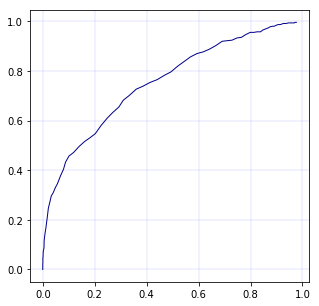

In [31]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(FPR, TPR, color='darkblue', linewidth=1)
ax.grid(color='b', linestyle='-', linewidth=0.1)
plt.show()

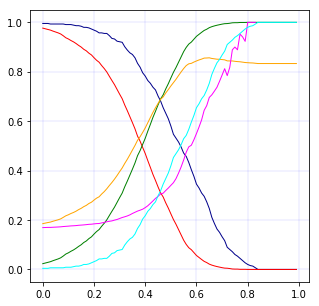

In [32]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(thresholdValues, TPR, color='darkblue', linewidth=1)
ax.plot(thresholdValues, FPR, color='red', linewidth=1)
ax.plot(thresholdValues, TNR, color='green', linewidth=1)
ax.plot(thresholdValues, ACC, color='orange', linewidth=1)
ax.plot(thresholdValues, PPV, color='magenta', linewidth=1)
ax.plot(thresholdValues, FNR, color='cyan', linewidth=1)
ax.grid(color='b', linestyle='-', linewidth=0.1)
plt.show()

In [35]:
gestures = Measurement.getFeatures(examinationData.filterData(lambda x : True))   
X = np.array(gestures)

pca = PCA(n_components = 4)
principalComponents  = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1',
                                      'principal component 2', 
                                      'principal component 3',
                                      'principal component 4'])

IDs = pd.DataFrame(list(map(lambda x: x.gestureId, examinationData.filterData(lambda x : True))),
                  columns=["gest"])

temp = [principalDf, IDs]
finalDf = pd.concat(temp, axis = 1)

targets = ['gest1', 'gest2', 'gest3', 'gest4', 'gest5', 'gest6']
colors = ['r', 'g', 'b', 'y', 'c', 'k']

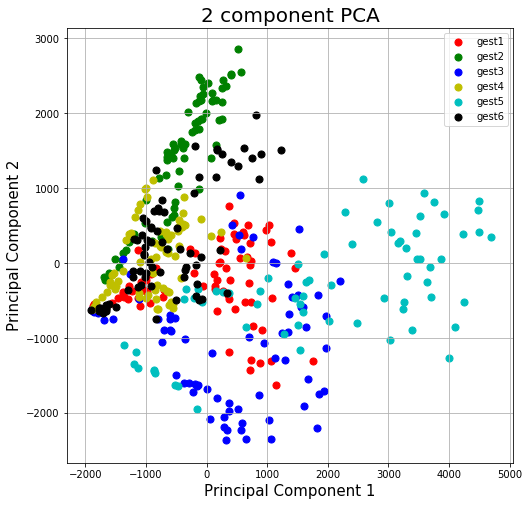

In [36]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['gest'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()
plt.show()

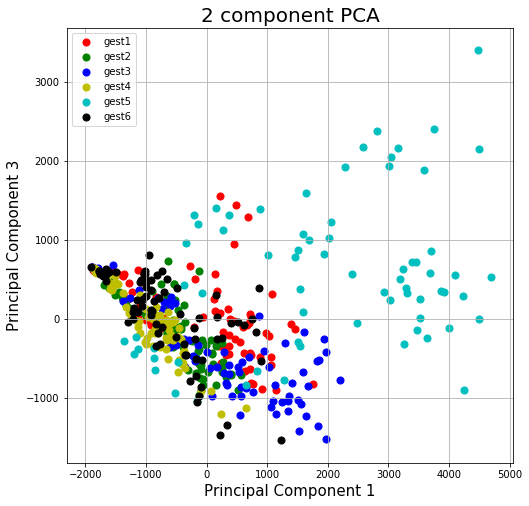

In [37]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['gest'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()
plt.show()

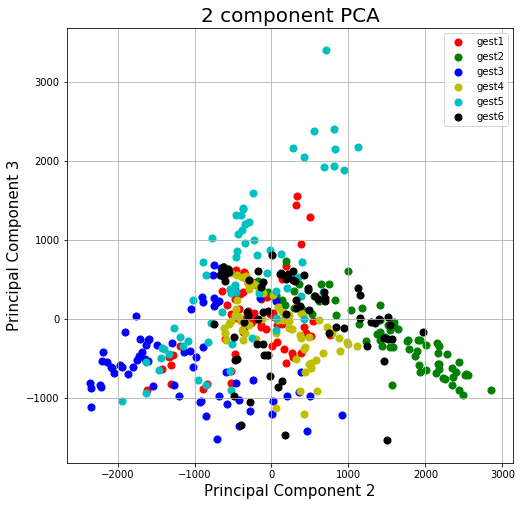

In [38]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['gest'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2'],
               finalDf.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()
plt.show()

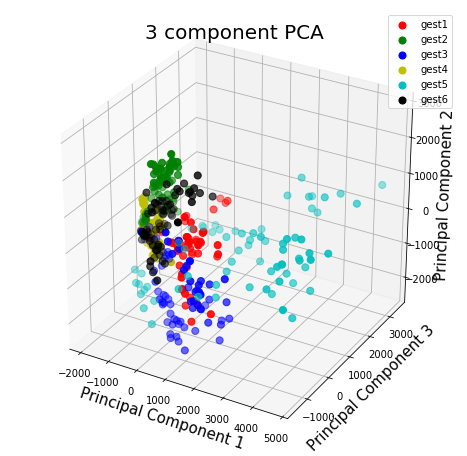

In [39]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_zlabel('Principal Component 2', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf["gest"] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 3'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

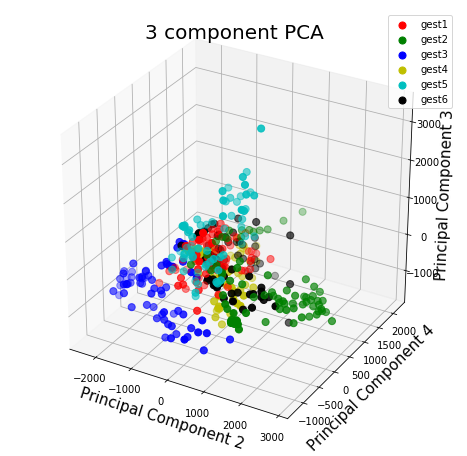

In [40]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1, projection='3d') 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 4', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf["gest"] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2'],
               finalDf.loc[indicesToKeep, 'principal component 4'],
               finalDf.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

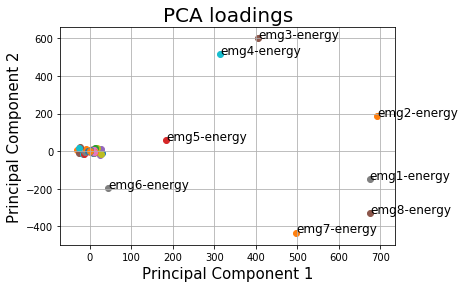

In [41]:
pcaLoadings = pca.components_.T * np.sqrt(pca.explained_variance_)
featuresList = ["".join((header._name_,'-',feature._name_)) for header in Channel for feature in FeaturesEnum]

fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA loadings', fontsize = 20)

for i in range (len(featuresList)) : 
    ax.scatter(pcaLoadings[i][0],
               pcaLoadings[i][1])
    
    if math.fabs(pcaLoadings[i][0]) > 30 or math.fabs(pcaLoadings[i][1] > 30) : 
        ax.text(pcaLoadings[i][0], pcaLoadings[i][1], featuresList[i], fontsize=12)
    
ax.grid()
plt.show()

In [42]:
from os import walk
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers.core import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import numpy as np
import re

Using TensorFlow backend.


In [43]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

In [256]:
def prepareNNVectors(mainGesture, featureLength, usePCA, Measurement):
    Y = []
    X = []
    Y_temp = []
    gestures = ["gest1", "gest2", "gest3", "gest4", "gest5", "gest6"]
    #mainGesture = 1
    #featureLength = 10

    for gesture in gestures:    
        selectedGestX = Measurement.getFeatures(examinationData.filterData(lambda x: x.gestureId == gesture \
                                                   and x.personId != "osoba1" \
                                                   and x.personId != "osoba2"))
        if (usePCA == 1):
            pca = PCA()
            #pca = PCA(n_components = 15)
            principalComponents  = pca.fit_transform(selectedGestX)
            selectedGestX = copy.deepcopy(principalComponents)
            
        if (int(gesture[4]) != mainGesture):
            selectedGestX = selectedGestX[0:featureLength]

        Y_temp = []
        for i in range(0,len(selectedGestX)):
            if (int(gesture[4]) == mainGesture):
                Y_temp.append(1)
            else:
                Y_temp.append(0)

        Y = Y + Y_temp
        X = X + selectedGestX
        #Y.append(Y_temp)
        #X.append(selectedGestX)
    Y = np.array(Y)
    X = np.array(X)
    return [X, Y]

def prepareNNTestVectors(mainGesture, usePCA, Measurement):
    Y_test2 = []
    X_test2 = []
    Y_temp = []
    gestures = ["gest1", "gest2", "gest3", "gest4", "gest5", "gest6"]
    #mainGesture = 1

    for gesture in gestures:    
        selectedGestX = Measurement.getFeatures(examinationData.filterData(lambda x: x.gestureId == gesture \
                                                   and x.personId != "osoba1" \
                                                   and x.personId != "osoba2"))

        if (usePCA == 1):
            pca = PCA()
            pca = PCA(n_components = 15)
            principalComponents  = pca.fit_transform(selectedGestX)
            selectedGestX = copy.deepcopy(principalComponents)
            
        Y_temp = []
        for i in range(0,len(selectedGestX)):
            if (int(gesture[4]) == mainGesture):
                Y_temp.append(1)
            else:
                Y_temp.append(0)

        Y_test2 = Y_test2 + Y_temp
        X_test2 = X_test2 + selectedGestX
        #Y.append(Y_temp)
        #X.append(selectedGestX)
    Y_test2 = np.array(Y_test2)
    X_test2 = np.array(X_test2)
    return [X_test2, Y_test2]

def prepareNNPersonTestVectors(mainGesture, usePCA, Measurement):
    Y_test = []
    X_test = []
    Y_temp = []
    gestures = ["gest1", "gest2", "gest3", "gest4", "gest5", "gest6"]
    mainGesture = 1

    for gesture in gestures:    
        selectedGestX = Measurement.getFeatures(examinationData.filterData(lambda x: x.gestureId == gesture \
                                                   and (x.personId == "osoba1" \
                                                   or x.personId == "osoba2")))
        
        if (usePCA == 1):
            pca = PCA()
            pca = PCA(n_components = 15)
            principalComponents  = pca.fit_transform(selectedGestX)
            selectedGestX = copy.deepcopy(principalComponents)
            
            
        Y_temp = []
        for i in range(0,len(selectedGestX)):
            if (int(gesture[4])==mainGesture):
                Y_temp.append(1)
            else:
                Y_temp.append(0)

        Y_test=Y_test+Y_temp
        X_test=X_test+selectedGestX
        #Y.append(Y_temp)
        #X.append(selectedGestX)

    Y_test=np.array(Y_test)
    X_test=np.array(X_test)
    return [X_test, Y_test]

In [201]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy

def createNN(firstL, secondL, inputSize):
    # create model
    model = Sequential()
    model.add(Dense(firstL, input_dim=inputSize, activation='relu'))
    model.add(Dense(secondL, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def fitModel(model, isVerboseOn):
    # Fit the model
    hist = model.fit(X, Y, epochs = 50, batch_size = 10, verbose = isVerboseOn)
    return [model, hist]

def visualizeTraining(hist):
    print('Quick visualization of model training history')
    plt.plot(hist.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
def fitModelUsingCrossValidation(X, Y, splits, firstL, secondL, inputSize):
    # fix random seed for reproducibility
    seed = 7
    numpy.random.seed(seed)

    # define N-fold cross validation test harness
    kfold = StratifiedKFold(n_splits = splits, shuffle = True, random_state = seed)
    cvscores = []
    isVerboseOn = 0
    for train, test in kfold.split(X, Y):
        # create model
        model = createNN(firstL, secondL, inputSize);
        [model, hist] = fitModel(model, isVerboseOn)
        # evaluate the model
        scores = model.evaluate(X[test], Y[test], verbose = 0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
    return model

def evaluateModel(X_test, Y_test, model):
    # evaluate the model
    scores = model.evaluate(X_test, Y_test)
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Quick visualization of model training history


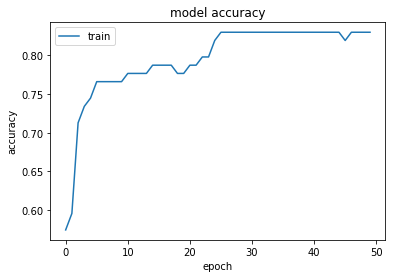

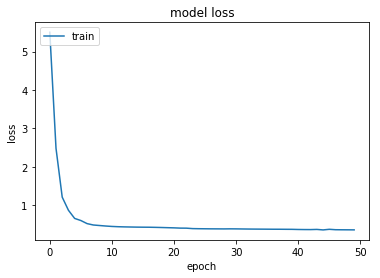

acc: 87.50%
Quick visualization of model training history


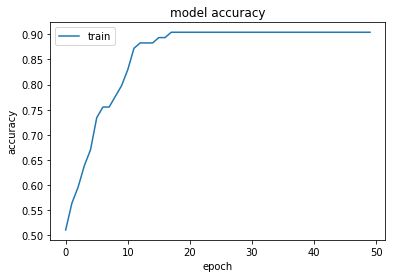

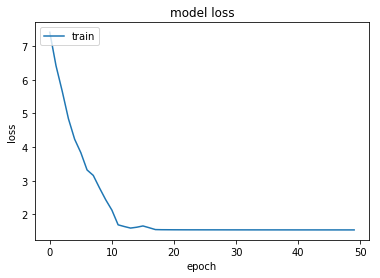

acc: 100.00%
Quick visualization of model training history


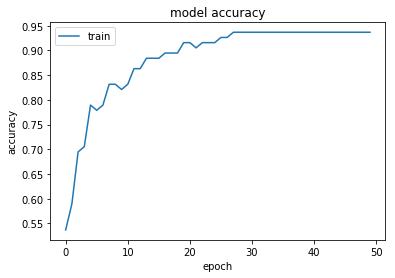

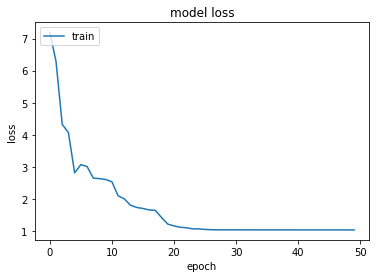

acc: 85.71%
Quick visualization of model training history


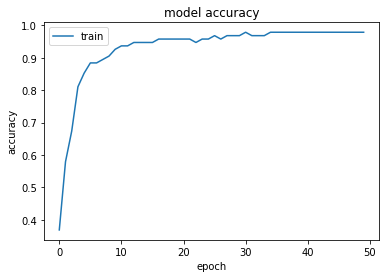

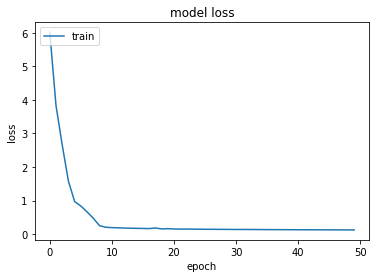

acc: 57.14%
Quick visualization of model training history


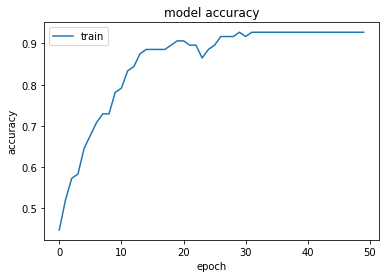

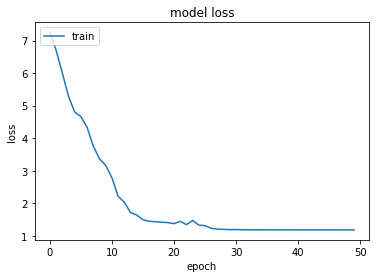

acc: 100.00%
Quick visualization of model training history


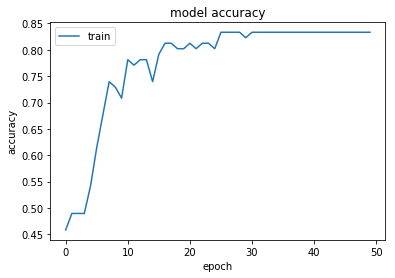

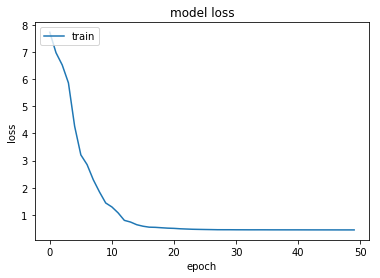

acc: 83.33%
Quick visualization of model training history


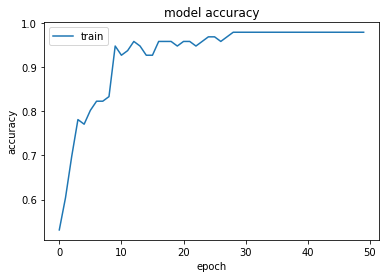

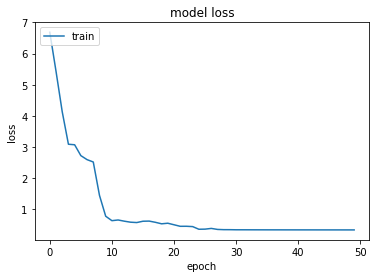

acc: 83.33%
Quick visualization of model training history


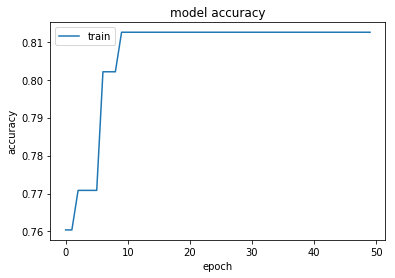

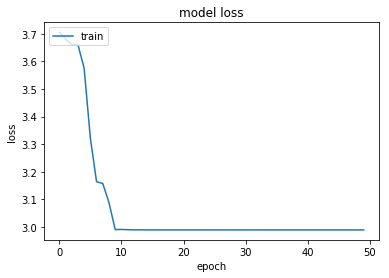

acc: 66.67%
Quick visualization of model training history


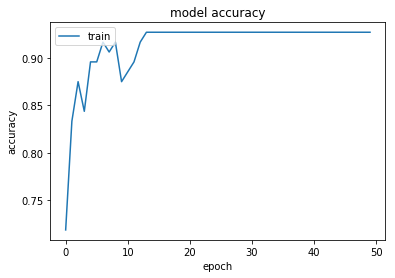

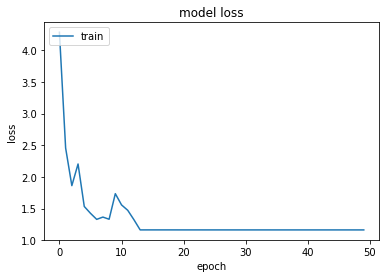

acc: 66.67%
Quick visualization of model training history


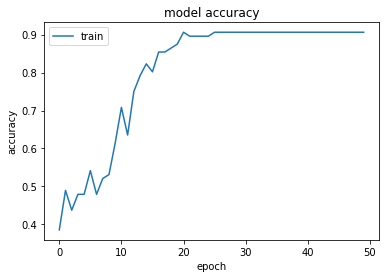

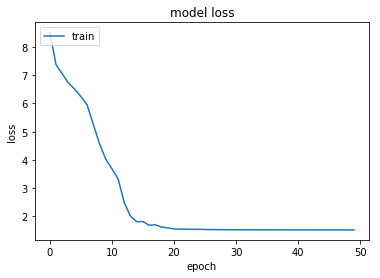

acc: 83.33%
Quick visualization of model training history


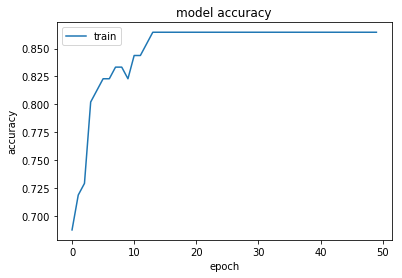

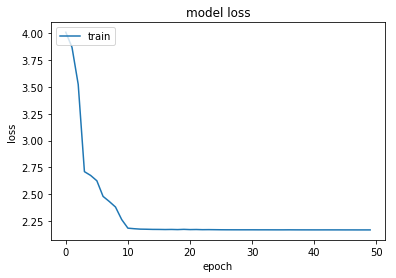

acc: 50.00%
Quick visualization of model training history


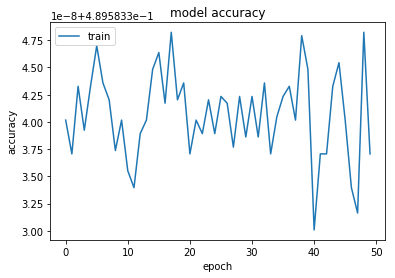

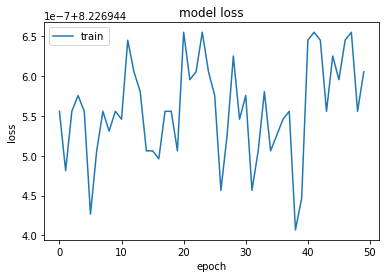

acc: 50.00%
Quick visualization of model training history


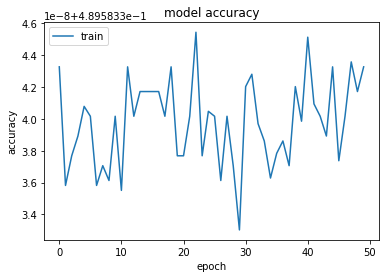

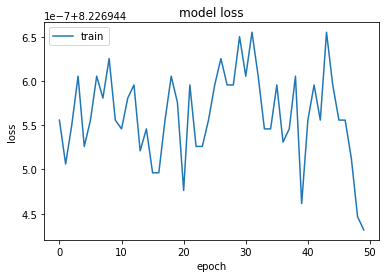

acc: 50.00%
Quick visualization of model training history


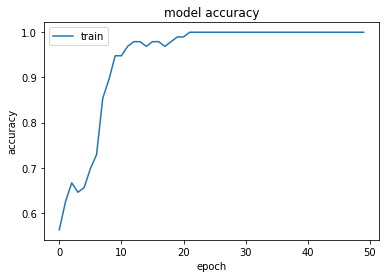

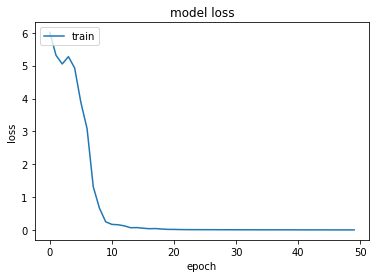

acc: 83.33%
Quick visualization of model training history


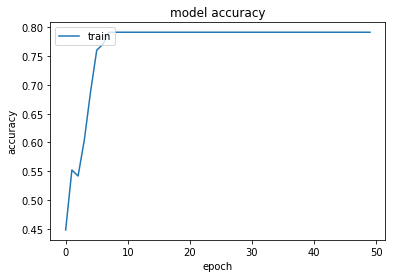

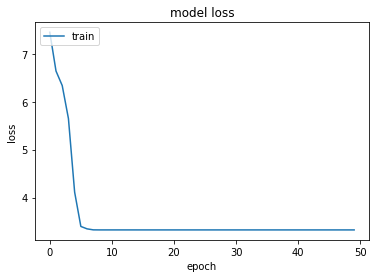

acc: 83.33%
Quick visualization of model training history


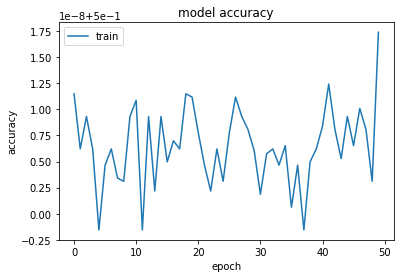

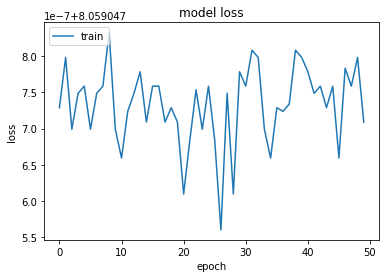

acc: 50.00%
73.77% (+/- 17.32%)


In [118]:
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=16, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model
	model = Sequential()
	model.add(Dense(10, input_dim=112, activation='relu'))
	model.add(Dense(7, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# Fit the model
	hist=model.fit(X[train], Y[train], epochs=50, batch_size=10, verbose=0) 
	print('Quick visualization of model training history')
	plt.plot(hist.history['acc'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(hist.history['loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train'], loc='upper left')
	plt.show()
	# evaluate the model
	scores = model.evaluate(X[test], Y[test], verbose=0)
	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
	cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

In [50]:
predictions = model.predict(X)
rounded = [round(x[0]) for x in predictions]
print(rounded)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]


In [119]:
# evaluate the model
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

125/125 [==============================] - 0s 64us/step

acc: 83.20%


In [120]:
# evaluate the model
scores = model.evaluate(X_test2, Y_test2)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

321/321 [==============================] - 0s 47us/step

acc: 83.80%


In [172]:
def teachNNToRecognizeGesture(mainGesture, usePCA, Measurement):
    featureLength = 10
    splits = 10

    [X, Y] = prepareNNVectors(mainGesture, featureLength, usePCA, Measurement)
    [X_test, Y_test] = prepareNNTestVectors(mainGesture, usePCA, Measurement)
    [X_testP, Y_testP] = prepareNNPersonTestVectors(mainGesture, usePCA, Measurement)

    firstL = 10
    secondL = 6
    inputSize = len(X[1])

    model = fitModelUsingCrossValidation(X, Y, splits, firstL, secondL, inputSize)
    print('Evaluation on the training group')
    evaluateModel(X, Y, model)
    print('Evaluation on the test group made from the same persons on which the NN was trained but different samples')
    evaluateModel(X_test, Y_test, model)
    print('Evaluation on the test group made from the samples from persons that were not in the train group')
    evaluateModel(X_testP, Y_testP, model)
    return model

In [157]:
modelForGesture1 = teachNNToRecognizeGesture(1, 0, Measurement)

acc: 45.45%
acc: 81.82%
acc: 50.00%
acc: 40.00%
acc: 70.00%
acc: 40.00%
acc: 30.00%
acc: 50.00%
acc: 50.00%
acc: 60.00%
51.73% (+/- 14.50%)
Evaluation on the training group
102/102 [==============================] - 0s 159us/step

acc: 48.04%
Evaluation on the test group made from the same persons on which the NN was trained but different samples
321/321 [==============================] - 0s 96us/step

acc: 20.56%
Evaluation on the test group made from the samples from persons that were not in the train group
125/125 [==============================] - 0s 128us/step

acc: 17.60%


In [158]:
modelForGesture2 = teachNNToRecognizeGesture(2, 0, Measurement)

acc: 90.91%
acc: 81.82%
acc: 45.45%
acc: 90.91%
acc: 100.00%
acc: 90.00%
acc: 80.00%
acc: 50.00%
acc: 50.00%
acc: 60.00%
73.91% (+/- 19.40%)
Evaluation on the training group
104/104 [==============================] - 0s 163us/step

acc: 52.88%
Evaluation on the test group made from the same persons on which the NN was trained but different samples
321/321 [==============================] - 0s 130us/step

acc: 23.68%
Evaluation on the test group made from the samples from persons that were not in the train group
125/125 [==============================] - 0s 128us/step

acc: 17.60%


In [159]:
modelForGesture3 = teachNNToRecognizeGesture(3, 0, Measurement)

acc: 100.00%
acc: 81.82%
acc: 45.45%
acc: 90.91%
acc: 100.00%
acc: 90.00%
acc: 80.00%
acc: 50.00%
acc: 50.00%
acc: 60.00%
74.82% (+/- 20.36%)
Evaluation on the training group
104/104 [==============================] - 0s 134us/step

acc: 52.88%
Evaluation on the test group made from the same persons on which the NN was trained but different samples
321/321 [==============================] - 0s 152us/step

acc: 23.68%
Evaluation on the test group made from the samples from persons that were not in the train group
125/125 [==============================] - 0s 112us/step

acc: 17.60%


In [160]:
modelForGesture4 = teachNNToRecognizeGesture(4, 0, Measurement)

acc: 45.45%
acc: 27.27%
acc: 50.00%
acc: 60.00%
acc: 50.00%
acc: 50.00%
acc: 40.00%
acc: 50.00%
acc: 60.00%
acc: 50.00%
48.27% (+/- 8.99%)
Evaluation on the training group
102/102 [==============================] - 0s 166us/step

acc: 43.14%
Evaluation on the test group made from the same persons on which the NN was trained but different samples
321/321 [==============================] - 0s 115us/step

acc: 17.45%
Evaluation on the test group made from the samples from persons that were not in the train group
125/125 [==============================] - 0s 136us/step

acc: 17.60%


In [161]:
modelForGesture5 = teachNNToRecognizeGesture(5, 0, Measurement)

acc: 63.64%
acc: 70.00%
acc: 50.00%
acc: 40.00%
acc: 60.00%
acc: 40.00%
acc: 40.00%
acc: 50.00%
acc: 50.00%
acc: 60.00%
52.36% (+/- 10.15%)
Evaluation on the training group
101/101 [==============================] - 0s 187us/step

acc: 51.49%
Evaluation on the test group made from the same persons on which the NN was trained but different samples
321/321 [==============================] - 0s 134us/step

acc: 22.74%
Evaluation on the test group made from the samples from persons that were not in the train group
125/125 [==============================] - 0s 144us/step

acc: 17.60%


In [162]:
modelForGesture6 = teachNNToRecognizeGesture(6, 0, Measurement)

acc: 72.73%
acc: 72.73%
acc: 45.45%
acc: 81.82%
acc: 54.55%
acc: 63.64%
acc: 36.36%
acc: 50.00%
acc: 50.00%
acc: 50.00%
57.73% (+/- 13.64%)
Evaluation on the training group
107/107 [==============================] - 0s 168us/step

acc: 52.34%
Evaluation on the test group made from the same persons on which the NN was trained but different samples
321/321 [==============================] - 0s 152us/step

acc: 23.99%
Evaluation on the test group made from the samples from persons that were not in the train group
125/125 [==============================] - 0s 144us/step

acc: 17.60%


In [238]:
import pandas
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [258]:
def trainDifferentModels(X_ML, Y):
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))

    results = []
    meanResult = []
    names = []
    scoring = 'accuracy'

    for name, model in models:
        kfold = model_selection.KFold(n_splits=15, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X_ML, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        meanResult.append(cv_results.mean())
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    return models

def prepareVectorsForML(mainGesture, Measurement):
    featureLength = 10
    usePCA = 0
    [X, Y] = prepareNNVectors(mainGesture, featureLength, usePCA, Measurement)
    [X_test, Y_test] = prepareNNTestVectors(mainGesture, usePCA, Measurement)
    [X_testP, Y_testP] = prepareNNPersonTestVectors(mainGesture, usePCA, Measurement)

    pca = PCA()
    pca = PCA(n_components = 15)
    X_ML  = pca.fit_transform(X)
    X_test_ML  = pca.fit_transform(X_test)
    X_testP_ML = pca.fit_transform(X_testP)
    return [X_ML, Y, X_test_ML, Y_test, X_testP_ML, Y_testP]


In [261]:
def evaluateOnTestGroup(models, X_ML, Y, X_test_ML, Y_test):
    # Predykcja na zbiorze walidacyjnym
    bestAlgorithmIndex = meanResult.index(np.max(meanResult))
    bestAlgorithmToValidation = models[bestAlgorithmIndex][1]

    bestAlgorithmToValidation.fit(X_ML, Y)
    predictions = bestAlgorithmToValidation.predict(X_test_ML)
    print("Confusion matrix")
    print(confusion_matrix(Y_test, predictions))
    print("\n\n{}\n{}".format("Tabela wyników", classification_report(Y_test, predictions)))

In [266]:
for i in range(1,6):
    mainGesture = i
    print('Evaluation of the gesture no ', i)
    [X_ML, Y, X_test_ML, Y_test, X_testP_ML, Y_testP] = prepareVectorsForML(mainGesture, Measurement)

    print('Evaluation on the training group')
    models = trainDifferentModels(X_ML, Y)
    
    print('Evaluation on training')
    evaluateOnTestGroup(models, X_ML, Y, X_ML, Y)
    
    print('Evaluation on the test group made from the same persons on which the NN was trained but different samples')
    evaluateOnTestGroup(models, X_ML, Y, X_test_ML, Y_test)

    print('Evaluation on the test group made from the samples from persons that were not in the train group')
    evaluateOnTestGroup(models, X_ML, Y, X_testP_ML, Y_testP)

Evaluation of the gesture no  1
Evaluation on the training group
LR: 0.865079 (0.218160)
LDA: 0.960317 (0.084142)
KNN: 0.884127 (0.216630)
CART: 0.734921 (0.320486)
NB: 0.893651 (0.218368)
SVM: 0.028571 (0.106904)
Evaluation on training
Confusion matrix
[[49  1]
 [ 1 51]]


Tabela wyników
             precision    recall  f1-score   support

          0       0.98      0.98      0.98        50
          1       0.98      0.98      0.98        52

avg / total       0.98      0.98      0.98       102

Evaluation on the test group made from the same persons on which the NN was trained but different samples
Confusion matrix
[[164 105]
 [ 15  37]]


Tabela wyników
             precision    recall  f1-score   support

          0       0.92      0.61      0.73       269
          1       0.26      0.71      0.38        52

avg / total       0.81      0.63      0.68       321

Evaluation on the test group made from the samples from persons that were not in the train group
Confusion matrix
[[4

W celu rozpoznania gestów postanowiono sprawdzić działanie kilku sposobów, które dążą do klasyfikacji. Pierwszym z nich było porównywanie odległości między wektorami cech, które osiągnęło średnio 70 % TPR przy 30 % EER. Postanowiono spróbować poprawić ten wynik przy użyciu sieci neuronowych jak i metod uczenia maszynowego. W tym celu podzielono dodatkowo zbiór danych na 4 podzbiory: uczący, walidacyjny i dwa testowe. Dwa zbiory testowe zostaly utworzone po to aby odróżnić sytuacje gdy wykonywany jest ten sam gest przez osobę, na której klasyfikator był uczony od sytuacji, w której ten sam gest wykonywany jest przez osobę, na której nie był on uczony. Do utworzenia zbioru walidacyjnego posłużyła metoda walidacji krzyżowej.

Przyjęto konwencję, że jeden klasyfikator służy do rozpoznawania tylko jednego gestu. Dzięki temu w przyszłym systemie łatwo dodawać kolejne gesty bez potrzeby późniejszego uczenia sieci czy też klasyfikatorów od nowa.

Dużym problemem było odpowiednie nauczenie sieci neuronowej. Wyniki uczenia przy korzystaniu z metodyki walidacji krzyżowej wskazują na to, że tak przygotowana sieć jest zdolna do generalizacji problemu (w najlepszym przypadku udało się uzyskać ponad 83 % skuteczności w przypadku obu zbiorów testowych, co jest wynikiem bardzo zadowalającym). Jednakże, ciężko uzyskać taką skuteczność i należy wielokrotnie przeprowadzać proces uczenia aby uzyskać sieć o odpowiadających właściwościach. Dodatkowo czasem dochodzi do zjawiska przeuczenia się sieci, jednakże przy obecnych jej parametrach nie jest to aż tak wielkim problemem.

Kolejnym podejściem, które zostało przetestowane to uczenie maszynowe z wykorzystaniem klasyfikatorów takich jak SVM, kNN czy też LDA. Okazało się, że najczęściej to właśnie liniowa analiza dyskryminacyjna jest najskuteczniejsza i jest możliwe uzyskanie skuteczności nawet powyżej 90 % przy jej użyciu, lecz również tutaj problemem jest odpowiednia generalizacja rozwiązania.

Przy użyciu obydwu metod uzyskano wyniki lepsze od klasycznego porównywania odległości między wektorami cech, szczególnie dobrze sprawdziła się jedna z wyuczonych sieci neuronowych (~83 % skuteczności) lecz bardzo ciężko otrzymać tego typu rezultat. Tym samym udało się udowodnić, że taka klasyfikacja jest jak najbardziej możliwa lecz można by zdecydowanie zwiększyć jej skuteczność posiadając większy zbiór danych.